### Importanto bibliotecas 

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

#Modelo
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from statsmodels.tsa.stattools import adfuller #teste de dicky fuller

plt.rcParams['figure.figsize'] = 20,10

#### Importanto Ativos



In [1]:
acao = ['ABEV3.SA']


In [4]:
df = yf.download(acao, start='2009-12-01', end='2023-01-01',interval='1mo' )['Adj Close']
df.head(5)

[*********************100%***********************]  3 of 3 completed


,ABEV3.SA,ITUB4.SA,PETR4.SA
Date,,,
2009-12-01,3.715230,10.269788,11.285086
2009-12-03,NaN,NaN,NaN
2009-12-21,NaN,NaN,NaN
2010-01-01,3.753812,9.590269,10.567766
2010-02-01,3.732038,9.688485,10.703845


## Tratando dados

In [4]:
df = df.to_frame()
df = df.rename(columns={'Adj Close':'ABEV3.SA'})
df.head()

,ABEV3.SA
Date,
2009-12-01,3.715230
2009-12-03,NaN
2010-01-01,3.753810
2010-02-01,3.732039
2010-03-01,3.454258


<AxesSubplot:xlabel='Date'>

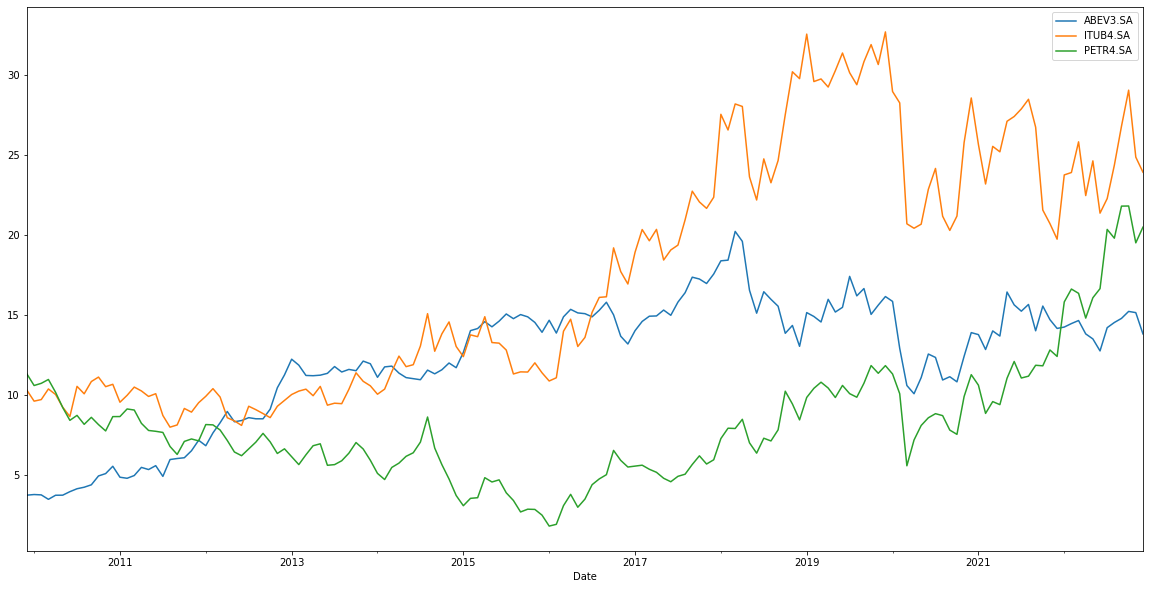

In [7]:
df.plot()

In [5]:
df.isna().sum()

ABEV3.SA    34
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

ABEV3.SA    0
ITUB4.SA    0
PETR4.SA    0
dtype: int64

In [7]:
df= df.reset_index()
df.dtypes

Date        datetime64[ns]
ABEV3.SA           float64
dtype: object

## Estatísticas 

In [8]:
df.describe()

,ABEV3.SA
count,157.000000
mean,12.208619
std,3.965305
min,3.454258
25%,10.912700
50%,13.659145
75%,15.012905
max,20.198647


## Autocorrelação da Série temporal

In [9]:
def acf (series):
    plot_acf(series)


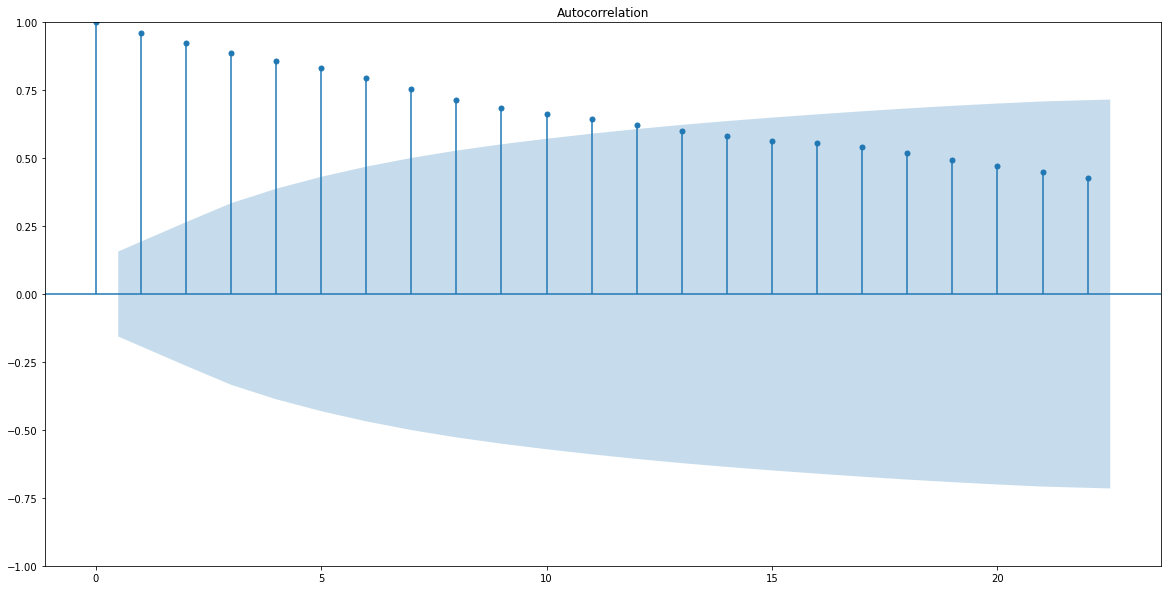

In [10]:
acf(df['ABEV3.SA'])

In [11]:
abev_analysis = df.copy()

abev_analysis.head(5)

,Date,ABEV3.SA
0,2009-12-01,3.715230
1,2010-01-01,3.753810
2,2010-02-01,3.732039
3,2010-03-01,3.454258
4,2010-04-01,3.709346


In [12]:
abev_analysis['Date']

0     2009-12-01
1     2010-01-01
2     2010-02-01
3     2010-03-01
4     2010-04-01
         ...    
152   2022-08-01
153   2022-09-01
154   2022-10-01
155   2022-11-01
156   2022-12-01
Name: Date, Length: 157, dtype: datetime64[ns]

In [13]:
start_date = '2010-01-01'
end_date = '2022-12-01'
xcoords = pd.date_range(start=start_date, end=end_date, freq='A')

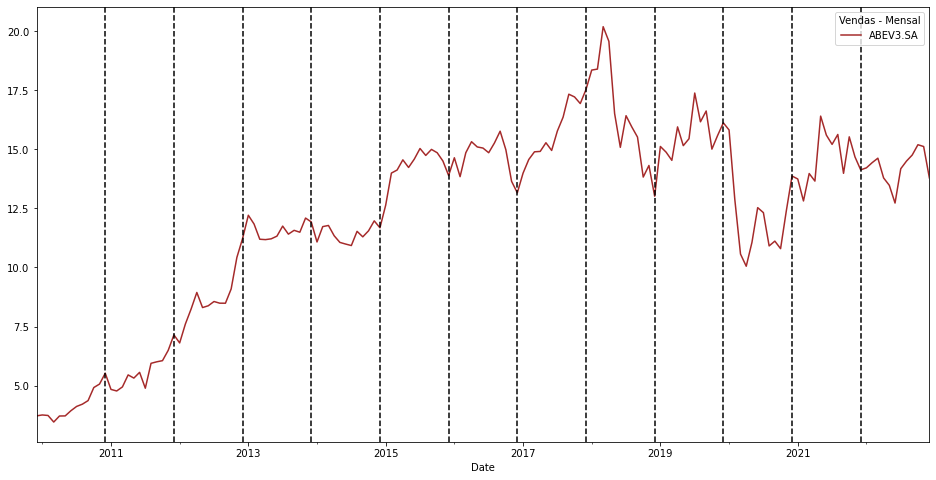

In [14]:

ax = abev_analysis.plot(x='Date', y='ABEV3.SA', figsize=(16,8), color='brown', legend=False)
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.legend(title = 'Vendas - Mensal')
plt.show()


## Decompondo a série

In [15]:
def decompose(acao):
    result = sm.tsa.seasonal_decompose(acao, model='multiplicative')

    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid


    fig, (ax1, ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15,9))
    result.observed.plot(ax=ax1, color='brown',ylabel='Observação', xlabel=' ',legend=False)
    ax1.axes.xaxis.set_visible(False)
    result.trend.plot(ax=ax2,color='brown',ylabel='Tendência',xlabel=' ',legend=False)
    ax2.axes.xaxis.set_visible(False)
    result.seasonal.plot(ax=ax3,color='brown', ylabel='Sazonal',xlabel=' ',legend=False)
    ax3.axes.xaxis.set_visible(False)
    result.resid.plot(ax=ax4,color='brown',ylabel='Residual',legend=False)
    plt.savefig("teste_sazonalidade_mensal.png",dpi=300)
    plt.show()

#### ABEV3.SA	BBAS3.SA	GGBR4.SA	PETR4.SA	VALE3.SA	WEGE3.SA

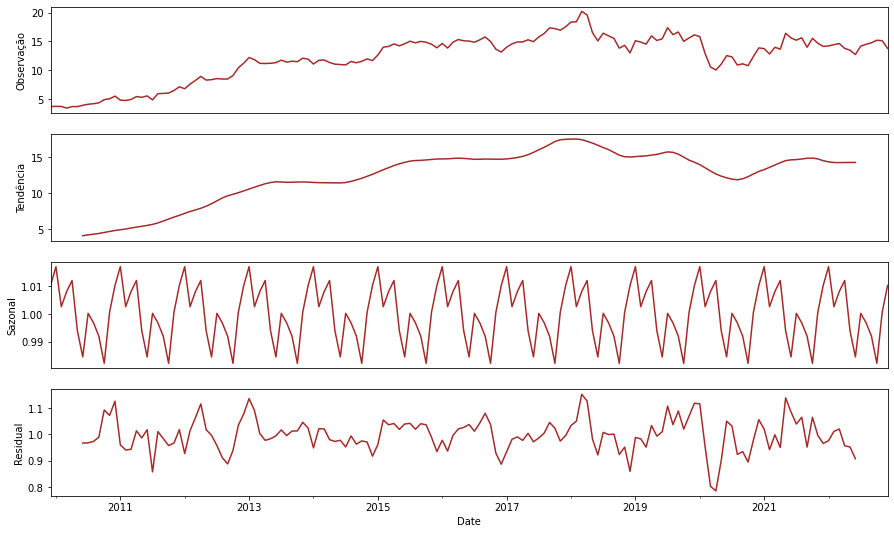

In [16]:
#ABEV3

ABEV3 = df.copy()

ABEV3.set_index('Date', inplace=True)


decompose(ABEV3)


## Tratando outliers

In [17]:
def remove_outlier(dados):

    quartil1 = dados.quantile(0.25)
    quartil3 = dados.quantile(0.75)

    interQuartil = quartil3 - quartil1

    limiteSuperior = quartil1 -(1.5* interQuartil) 
    limiteInferior = quartil3 - (1.5 * interQuartil)



    dados_final = dados.apply(lambda x: x if (x> limiteInferior) or (x< limiteSuperior) else dados.mean())
    
    return dados_final



In [18]:
df_tratado = pd.DataFrame()
for cols in df.columns:
 
    df_tratado['ABEV3.SA'] = remove_outlier(ABEV3['ABEV3.SA'])


df_tratado.head(5)

,ABEV3.SA
Date,
2009-12-01,3.715230
2010-01-01,3.753810
2010-02-01,3.732039
2010-03-01,3.454258
2010-04-01,3.709346


<AxesSubplot:>

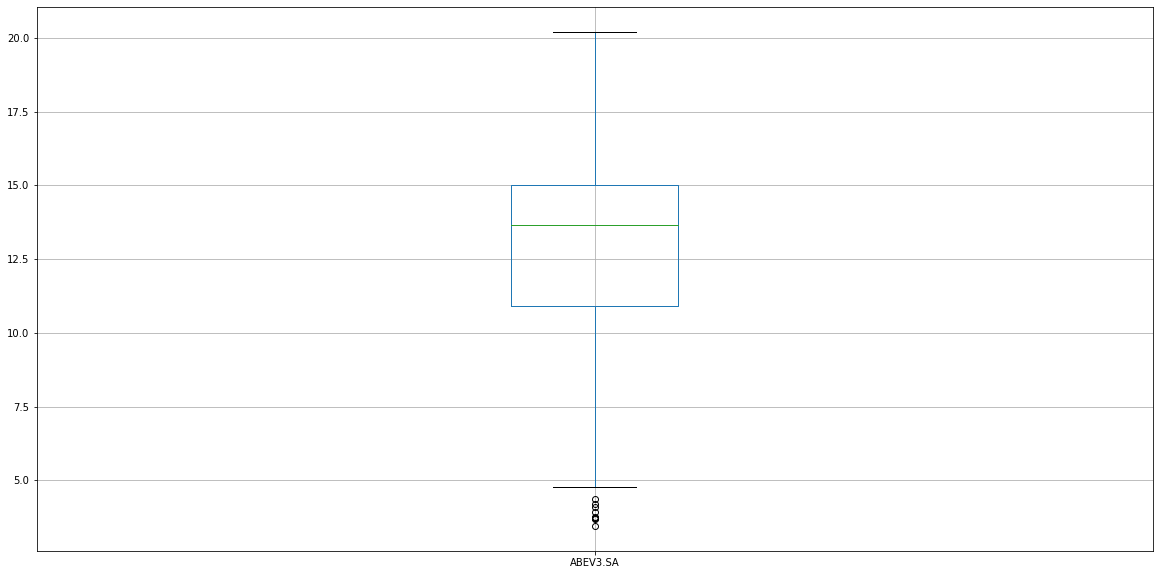

In [19]:
df.boxplot()

<AxesSubplot:>

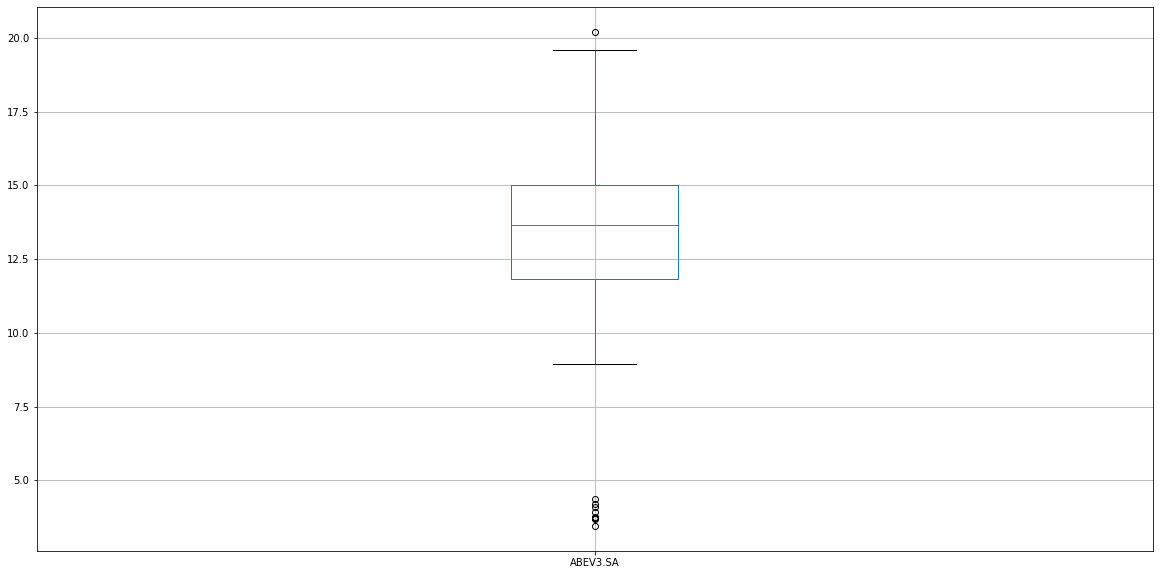

In [20]:

df_tratado.boxplot()


### Projeção - Escolhendo os atributos do modelo

In [21]:
df.set_index('Date')
analysis = df.copy()
analysis.dtypes

Date        datetime64[ns]
ABEV3.SA           float64
dtype: object

In [29]:

#Find minimal AIC value for the ARIMA model integers



p = range(0,2)
d = range(0,2)
q = range(0,2)

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(diff_abev,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

      

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-388.25236852815874
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-358.3585046362932
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-275.84343040207347
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-299.57606353007225
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-359.05626232901
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-358.58316816969614
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-275.7764204979733
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-288.5051540031325
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-382.74671131090327
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-353.0309206927434
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-270.94169413435264
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-296.28725003802924
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-357.05652278037167
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-353.33382818057805
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-274.019255427812
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-285.5329847529406
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-278.3696689852034
SARIMAX(

In [30]:
model_abev = auto_arima(diff_abev, start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                        suppress_warnings = True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-177.930, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-223.627, Time=0.13 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-223.786, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-198.290, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-222.920, Time=0.35 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-220.881, Time=0.26 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-226.056, Time=0.59 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=-224.133, Time=0.73 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,1)(2,1,0)[12]      

#### Transformando em série estacionária 

In [25]:
#Teste de estacionariedade Dickey Fuller

def adf_test(dados):
    print('Resultado do Teste Dickey-Fuller:')
    adftest = adfuller(dados, autolag = 'AIC') # Faz o teste de Dickey Fuller e obtem a metrica de avalição AIC -> AKAIKE INFORMATION CRITERION
    output = pd.Series(adftest[0:4], index=['Teste', 'Valor de P', 'Numeros de lags', 'Numeros de observações']) # atribue titulo as series
    for key, value in adftest[4].items():
        output['Valor Crítico ({})'.format(key)] = value
    print(output)

In [26]:
# Transformando em Estacionária 
def diff(dados):
    diff_dados = dados.pct_change()
    diff_dados.dropna(inplace=True)
    return diff_dados

In [51]:
adf_test(ABEV3)

Resultado do Teste Dickey-Fuller:
Teste                      -2.341718
Valor de P                  0.158866
Numeros de lags             9.000000
Numeros de observações    147.000000
Valor Crítico (1%)         -3.475637
Valor Crítico (5%)         -2.881410
Valor Crítico (10%)        -2.577365
dtype: float64


In [52]:
diff_abev = diff(ABEV3)
adf_test(diff_abev)

Resultado do Teste Dickey-Fuller:
Teste                      -3.776818
Valor de P                  0.003154
Numeros de lags             5.000000
Numeros de observações    150.000000
Valor Crítico (1%)         -3.474715
Valor Crítico (5%)         -2.881009
Valor Crítico (10%)        -2.577151
dtype: float64


## Aplicando o modelo estatistico 

In [31]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [32]:
ABEV3= ABEV3.asfreq('MS')


In [33]:
list_param = []
list_param_seasonal = []
list_results_aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff_abev,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-388.25236852815874
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-358.3585046362932
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-275.84343040207347
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-299.57606353007225
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-359.05626232901
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-358.58316816969614
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-275.7764204979733
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-288.5051540031325
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-382.74671131090327
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-353.0309206927434
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-270.94169413435264
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-296.28725003802924
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-357.05652278037167
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-353.33382818057805
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-274.019255427812
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-285.5329847529406
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-278.3696689852034
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-257.

In [34]:
aic_abev= pd.DataFrame({'{}':list_param,'{}12':list_param_seasonal, 'AIC':list_results_aic}).sort_values(by='AIC')

In [35]:
aic_abev.max()

{}          (1, 1, 1)
{}12    (1, 1, 1, 12)
AIC       -176.633401
dtype: object

In [36]:
mod = sm.tsa.statespace.SARIMAX(diff_abev.astype(float),
                                order= (0, 1, 0),
                                seasonal_order=(2,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4973      0.092     -5.402      0.000      -0.678      -0.317
ar.S.L24      -0.4619      0.109     -4.234      0.000      -0.676      -0.248
sigma2         0.0110      0.001      8.844      0.000       0.009       0.013


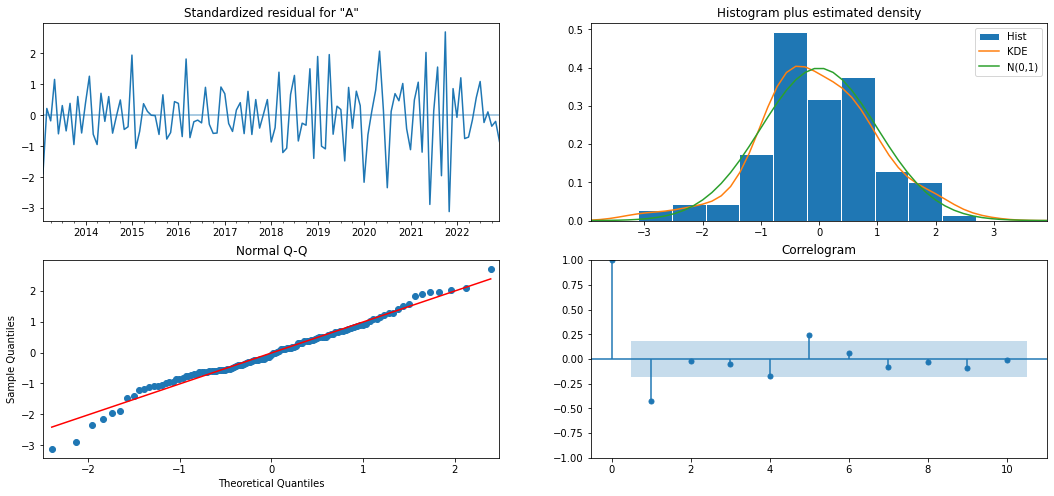

In [37]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

**Os gráficos residuais para o modelo automático SARIMA parecem muito bons.**

* **Histograma mais gráfico de densidade estimada:** A linha  KDE segue de perto com a linha N(0,1). Esta é uma boa indicação de que os resíduos são normalmente distribuídos.

* **O QQ-plot:** Mostra que a distribuição ordenada dos resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1). Esta é uma indicação de que os resíduos são normalmente distribuídos.

* **O gráfico de resíduos padronizados:** Os resíduos ao longo do tempo não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

* **O gráfico do Correlograma:** Mostra que os resíduos da série temporal têm baixa correlação com as versões defasadas de si mesmo.  A distribuição e a função de Auto correlação ACF (correlograma). Valores acima do “0” têm alguma correlação com os dados da série temporal. Valores próximos a “1” demonstram a correlação mais forte


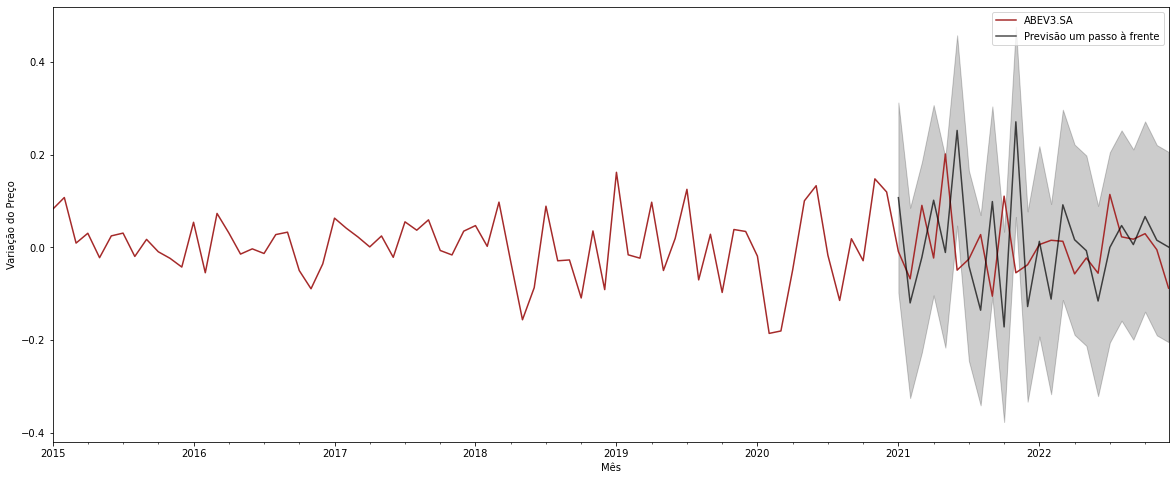

In [38]:
# Treino do Modelo para Previsão
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = diff_abev['2015':].plot(label='observed', color='brown')
pred.predicted_mean.plot(ax=ax, label='Previsão um passo à frente', alpha=.7, figsize=(20, 8), color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Variação do Preço')
plt.legend()
plt.xlabel('Mês')
# plt.savefig("vendas_sarimax.png",dpi=300)
plt.show()

In [39]:
# Cálculo do Erro
y_forecasted = pred.predicted_mean
y_truth = diff_abev['ABEV3.SA']['2021-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('====================================================')
print('O erro quadrático médio é {}'.format(round(mse, 2)))
print('A raiz do erro quadrático médio é {}'.format(round(np.sqrt(mse), 2)))
print('====================================================')

O erro quadrático médio é 0.02
A raiz do erro quadrático médio é 0.14


## PREVISÃO DOS PROXIMOS 6 MESES

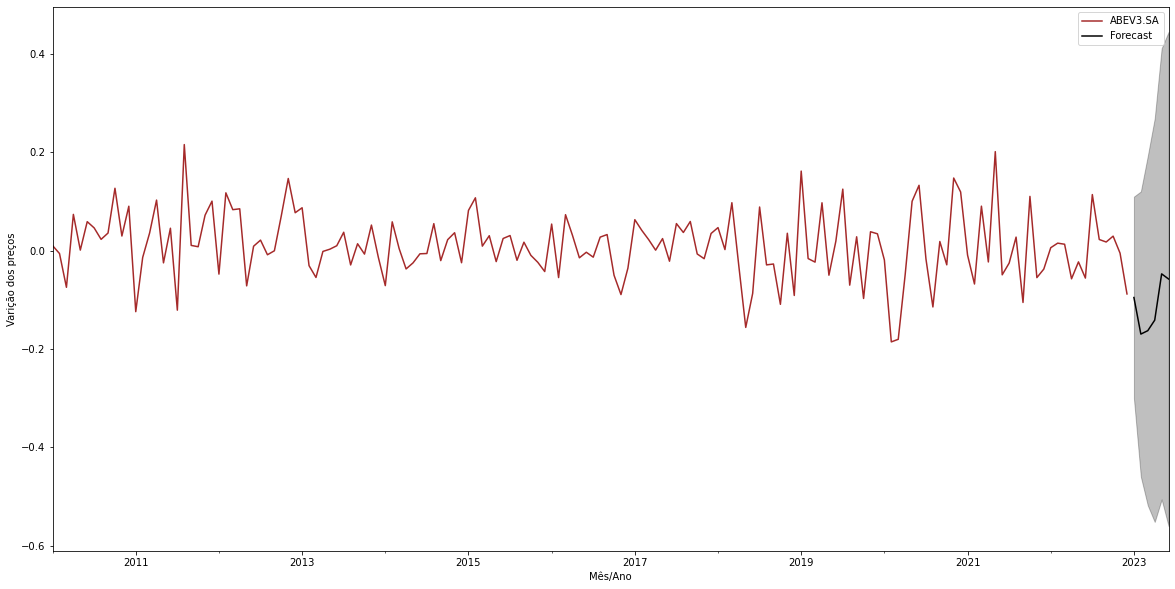

In [40]:
# Previsão para os próximos meses
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = diff_abev.plot(label='Variacao do preço', color='brown')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast',color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Varição dos preços')
ax.legend(['variação conhecida','Forecast'])
plt.xlabel('Mês/Ano')
# plt.savefig("forecast.png",dpi=150)
plt.legend()
plt.show()

In [41]:
forecast = pred_ci
forecast['Forecast'] = pred_uc.predicted_mean
forecast.astype(float)

,lower ABEV3.SA,upper ABEV3.SA,Forecast
2023-01-01,-0.300341,0.109952,-0.095194
2023-02-01,-0.459691,0.120550,-0.169571
2023-03-01,-0.517976,0.192672,-0.162652
2023-04-01,-0.551557,0.269029,-0.141264
2023-05-01,-0.505834,0.411608,-0.047113
2023-06-01,-0.560050,0.444958,-0.057546


In [42]:

predictions_pct = pd.DataFrame(forecast, columns={'lower ABEV3.SA',	'upper ABEV3.SA',	'Forecast','lower price', 'upper price', 'price'}).copy()
previous_price = ABEV3['ABEV3.SA'].iloc[-1]


for i in range(len(predictions_pct)): 
    predictions_pct['price'][i] = previous_price * (1  +  (predictions_pct['Forecast'][i]))
    predictions_pct['lower price'][i] = previous_price * (1  +  (predictions_pct['lower ABEV3.SA'][i]))
    predictions_pct['upper price'][i] = previous_price * (1  +  (predictions_pct['upper ABEV3.SA'][i]))
    # print(predictions_pct['price'][i] ,' preço:', previous_price, 'variacao',predictions_pct['Forecast'][i] )
    previous_price = predictions_pct['price'][i]

# Exibindo as previsões dos preços
predictions_pct

,Forecast,upper ABEV3.SA,upper price,lower price,lower ABEV3.SA,price
2023-01-01,-0.095194,0.109952,15.309832,9.650567,-0.300341,12.480200
2023-02-01,-0.169571,0.120550,13.984691,6.743160,-0.459691,10.363926
2023-03-01,-0.162652,0.192672,12.360765,4.995664,-0.517976,8.678215
2023-04-01,-0.141264,0.269029,11.012905,3.891688,-0.551557,7.452296
2023-05-01,-0.047113,0.411608,10.519722,3.682668,-0.505834,7.101195
2023-06-01,-0.057546,0.444958,10.260928,3.124172,-0.560050,6.692550


In [43]:
df_forecast = predictions_pct.reset_index().copy()
df_forecast['mes'] = df_forecast['index'].dt.month
df_forecast['ano'] = df_forecast['index'].dt.year
df_forecast['Trimestre'] = df_forecast['mes'].apply(lambda x: '1º Trismestre' if x>8 else ('2º Trimestre' if (x>4 and x< 9) else '1º Trimestre'))
df_forecast

,index,Forecast,upper ABEV3.SA,upper price,lower price,lower ABEV3.SA,price,mes,ano,Trimestre
0,2023-01-01,-0.095194,0.109952,15.309832,9.650567,-0.300341,12.480200,1,2023,1º Trimestre
1,2023-02-01,-0.169571,0.120550,13.984691,6.743160,-0.459691,10.363926,2,2023,1º Trimestre
2,2023-03-01,-0.162652,0.192672,12.360765,4.995664,-0.517976,8.678215,3,2023,1º Trimestre
3,2023-04-01,-0.141264,0.269029,11.012905,3.891688,-0.551557,7.452296,4,2023,1º Trimestre
4,2023-05-01,-0.047113,0.411608,10.519722,3.682668,-0.505834,7.101195,5,2023,2º Trimestre
5,2023-06-01,-0.057546,0.444958,10.260928,3.124172,-0.560050,6.692550,6,2023,2º Trimestre


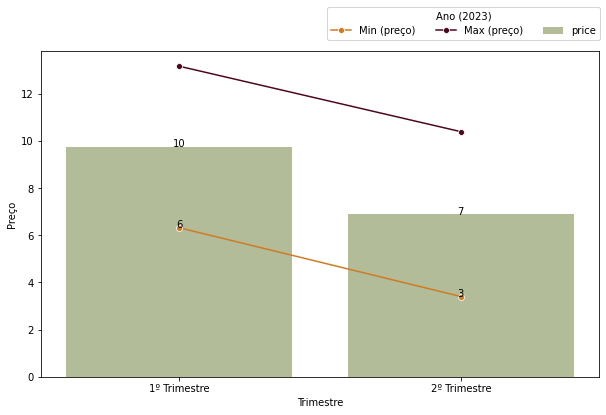

<Figure size 1440x720 with 0 Axes>

In [44]:
#palette=['#4c061d','#d17a22', '#b4c292'])#

df_aux = df_forecast[df_forecast['ano']==2023].groupby(['Trimestre','ano']).agg({'price':'mean',
                                                                                    'lower price':'mean',
                                                                                    'upper price':'mean'}).reset_index()
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(x='Trimestre', y='price',
                 data=df_aux, palette=['#b4c292'], label='price') 

ax = sns.barplot(x='Trimestre', y='lower price',
                 data=df_aux, palette=['#b4c292'], alpha=0) 

# ax = sns.barplot(x='quadrimestre', y='upper price',
#                  data=df_aux, palette=['#b4c292'], alpha=0) 

ax = sns.lineplot(x='Trimestre', y='lower price',label='Min (preço)',
                 data=df_aux, color='#d17a22',marker='o') 

ax = sns.lineplot(x='Trimestre', y='upper price',
                 data=df_aux, color='#4c061d',marker='o',label = 'Max (preço)') 

plt.legend(title='Ano (2023)',ncol=3,bbox_to_anchor=(1.01, 1.15))
plt.xlabel('Trimestre')
plt.ylabel('Preço')
for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate('{:.0f}'.format(p.get_height()), (x, y), ha='center')
plt.show()
plt.savefig("preços Trimestre_abev.png",dpi=150)



In [45]:
ABEV3

,ABEV3.SA
Date,
2009-12-01,3.715230
2010-01-01,3.753810
2010-02-01,3.732039
2010-03-01,3.454258
2010-04-01,3.709346
...,...
2022-08-01,14.505698
2022-09-01,14.762184
2022-10-01,15.199160


In [46]:
df_forecast = df_forecast.set_index('index')
pred_abev = pd.DataFrame()
pred_abev['price'] = ABEV3['ABEV3.SA'].append(df_forecast['price'], ignore_index=True)
pred_abev['Date'] = ABEV3.index.append(df_forecast.index)
pred_abev = pred_abev.set_index('Date')
pred_abev

,price
Date,
2009-12-01,3.715230
2010-01-01,3.753810
2010-02-01,3.732039
2010-03-01,3.454258
2010-04-01,3.709346
...,...
2023-02-01,10.363926
2023-03-01,8.678215
2023-04-01,7.452296


<AxesSubplot:xlabel='Date'>

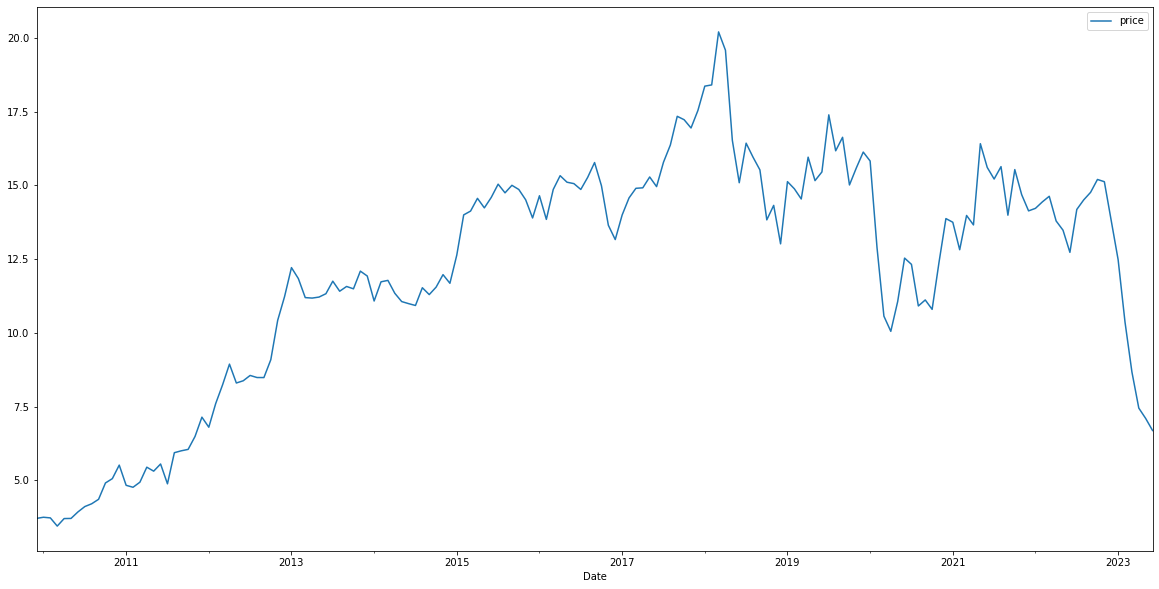

In [47]:

pred_abev.plot()